In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

In [2]:
# Generate data
hourly_f1 = list(np.random.randint(low=94, high=98, size=24*20)) + \
            list(np.random.randint(low=92, high=96, size=24*5)) + \
            list(np.random.randint(low=88, high=96, size=24*5)) + \
            list(np.random.randint(low=86, high=92, size=24*5))

In [3]:
# Cumulative f1
cumulative_f1 = [np.mean(hourly_f1[:n]) for n in range(1, len(hourly_f1)+1)]
print (f"Average cumulative f1 on the last day: {np.mean(cumulative_f1[-24:]):.1f}")

Average cumulative f1 on the last day: 93.7


In [4]:
# Sliding f1; takes the weighted average (equal though) of values in a sliding window
window_size = 24
sliding_f1 = np.convolve(hourly_f1, np.ones(window_size)/window_size, mode="valid")
print (f"Average sliding f1 on the last day: {np.mean(sliding_f1[-24:]):.1f}")

Average sliding f1 on the last day: 88.5


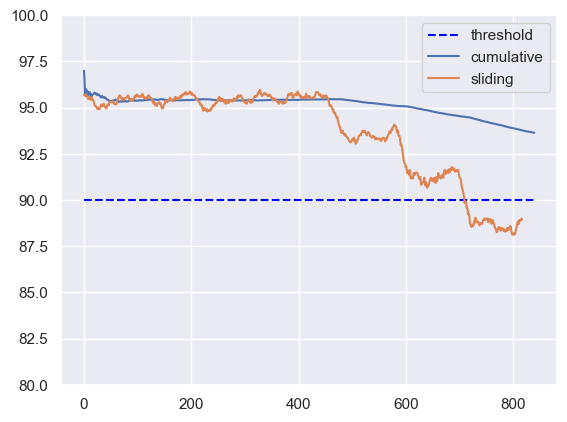

In [5]:
plt.ylim([80, 100])
plt.hlines(y=90, xmin=0, xmax=len(hourly_f1), colors="blue", linestyles="dashed", label="threshold")
plt.plot(cumulative_f1, label="cumulative")
plt.plot(sliding_f1, label="sliding")
plt.legend()

In [6]:
import great_expectations as ge
import json
import pandas as pd
from urllib.request import urlopen

In [7]:
# Load labeled projects
projects = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv")
tags = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv")
df = ge.dataset.PandasDataset(pd.merge(projects, tags, on="id"))
df["text"] = df.title + " " + df.description
df.drop(["title", "description"], axis=1, inplace=True)
df.head(5)

,id,created_on,tag,text
0,6,2020-02-20 06:43:18,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,graph-learning,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,reinforcement-learning,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,graph-learning,Diffusion to Vector Reference implementation o...


In [8]:
# Simulated production data
prod_df = ge.dataset.PandasDataset([{"text": "hello"}, {"text": 0}, {"text": "world"}])

In [9]:
# Expectation suite
df.expect_column_values_to_not_be_null(column="text")
df.expect_column_values_to_be_of_type(column="text", type_="str")
expectation_suite = df.get_expectation_suite()

In [10]:
# Validate reference data
df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 2,
 'unsuccessful_expectations': 0,
 'success_percent': 100.0}

In [11]:
# Validate production data
prod_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 1,
 'unsuccessful_expectations': 1,
 'success_percent': 50.0}

In [12]:
from alibi_detect.cd import KSDrift

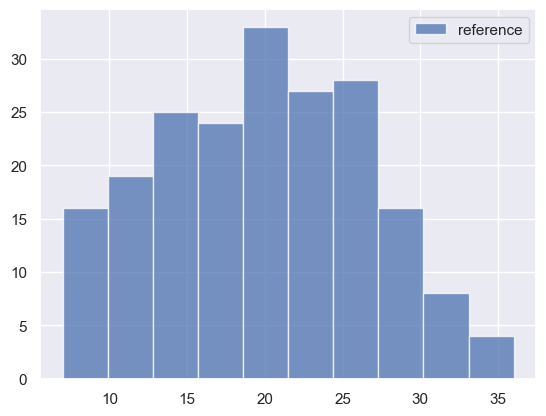

In [13]:
# Reference; number of tokens distribution over 200 training examples
df["num_tokens"] = df.text.apply(lambda x: len(x.split(" ")))
ref = df["num_tokens"][0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()
plt.show()

In [14]:
# Initialize drift detector
length_drift_detector = KSDrift(ref, p_val=0.01)

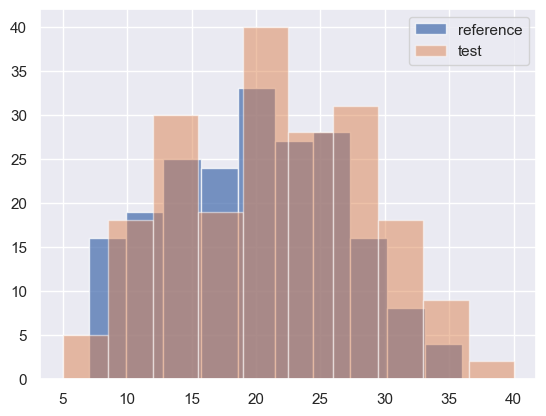

In [15]:
# No drift
no_drift = df["num_tokens"][200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [16]:
# labeled as a zero; high p value of 0.37 meaning distributions are similar
length_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': array([0.09], dtype=float32),
  'p_val': array([0.37063202], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.1',
  'detector_type': 'drift'}}

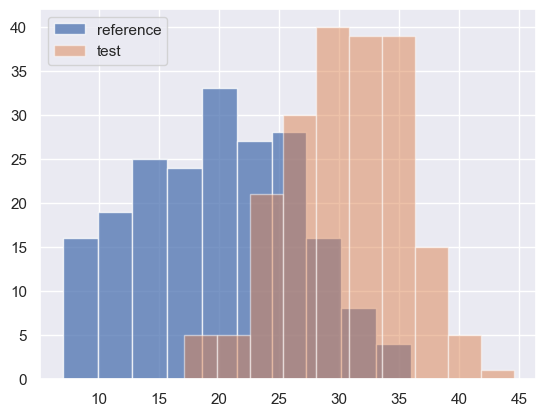

In [17]:
# Drift
drift = np.random.normal(30, 5, len(ref))
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [18]:
length_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([0.645], dtype=float32),
  'p_val': array([4.444e-41], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.1',
  'detector_type': 'drift'}}

In [19]:
from alibi_detect.cd import ChiSquareDrift

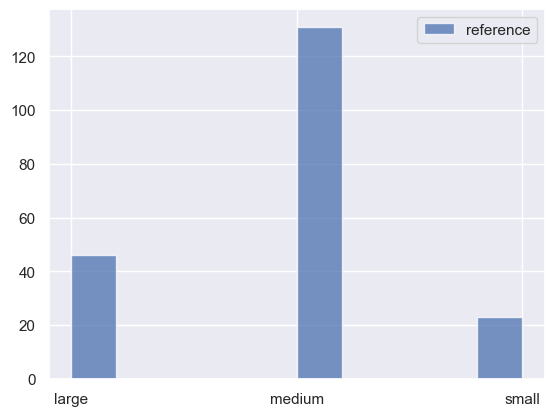

In [20]:
# Reference
df.token_count = df.num_tokens.apply(lambda x: "small" if x <= 10 else ("medium" if x <=25 else "large"))
ref = df.token_count[0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()

In [21]:
# Initialize drift detector
target_drift_detector = ChiSquareDrift(ref, p_val=0.01)

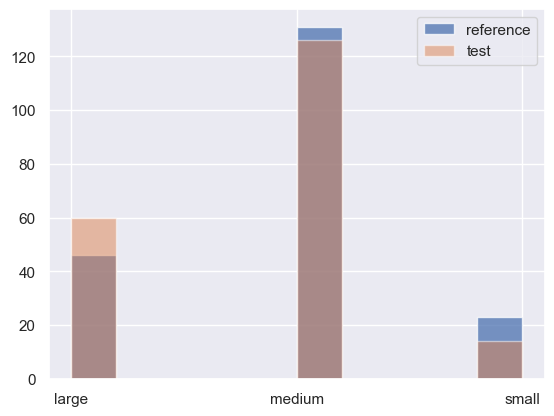

In [22]:
# No drift
no_drift = df.token_count[200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [23]:
target_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)


{'data': {'is_drift': 0,
  'distance': array([4.135522], dtype=float32),
  'p_val': array([0.12646863], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.1',
  'detector_type': 'drift'}}

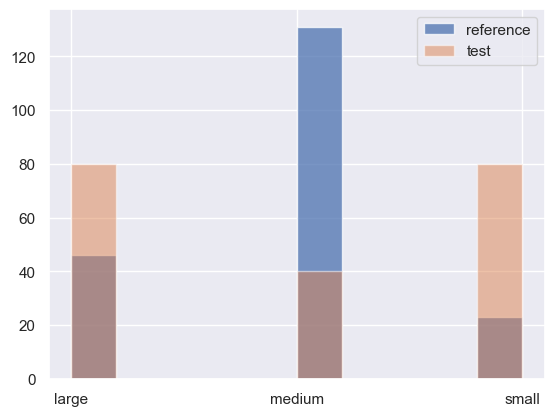

In [24]:
# Drift
drift = np.array(["small"]*80 + ["medium"]*40 + ["large"]*80)
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [25]:
target_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([89.145195], dtype=float32),
  'p_val': array([4.389017e-20], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.1',
  'detector_type': 'drift'}}

In [26]:
from transformers import AutoTokenizer

In [27]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
vocab_size = len(tokenizer)
print (vocab_size)

31090


In [28]:
# Tokenize inputs
encoded_input = tokenizer(df.text.tolist(), return_tensors="pt", padding=True)
ids = encoded_input["input_ids"] # lookup for the embeddings 
masks = encoded_input["attention_mask"] # masks for the attention

In [29]:
# Decode
print (f"{ids[0]}\n{tokenizer.decode(ids[0])}")

tensor([  102,  2029,   467,  1778,   609,   137,  6446,  4857,   191,  1332,
         2399, 13572, 19125,  1983,   147,  1954,   165,  6240,   205,   185,
          300,  3717,  7434,  1262,   121,   537,   201,   137,  1040,   111,
          545,   121,  4714,   205,   103,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])
[CLS] comparison between yolo and rcnn on real world videos bringing theory to experiment is cool. we can easily train models in colab and find the results in minutes. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [30]:
# Sub-word tokens
print (tokenizer.convert_ids_to_tokens(ids=ids[0]))

['[CLS]', 'comparison', 'between', 'yo', '##lo', 'and', 'rc', '##nn', 'on', 'real', 'world', 'videos', 'bringing', 'theory', 'to', 'experiment', 'is', 'cool', '.', 'we', 'can', 'easily', 'train', 'models', 'in', 'col', '##ab', 'and', 'find', 'the', 'results', 'in', 'minutes', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [31]:
from alibi_detect.models.pytorch import TransformerEmbedding

In [32]:
# Embedding layer
emb_type = "hidden_state"
layers = [-x for x in range(1, 9)]  # last 8 layers
embedding_layer = TransformerEmbedding(model_name, emb_type, layers)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# Embedding dimension
embedding_dim = embedding_layer.model.embeddings.word_embeddings.embedding_dim
embedding_dim

768

In [34]:
import torch
import torch.nn as nn

In [35]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [36]:
# Untrained autoencoder (UAE) reducer
encoder_dim = 32
reducer = nn.Sequential(
    embedding_layer,
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, encoder_dim)
).to(device).eval()

In [37]:
from alibi_detect.cd.pytorch import preprocess_drift
from functools import partial

In [38]:
# Preprocessing with the reducer; converts 768 down to 32 dims
max_len = 100
batch_size = 32
preprocess_fn = partial(preprocess_drift, model=reducer, tokenizer=tokenizer,
                        max_len=max_len, batch_size=batch_size, device=device)

In [39]:
from alibi_detect.cd import MMDDrift

In [40]:
# Reference
ref = df.text[0:200].to_list()

In [41]:
# Initialize drift detector
mmd_drift_detector = MMDDrift(ref, backend="pytorch", p_val=.01, preprocess_fn=preprocess_fn)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
No GPU detected, fall back on CPU.


In [42]:
# No drift
no_drift = df.text[200:400].to_list()
mmd_drift_detector.predict(no_drift)

{'data': {'is_drift': 0,
  'distance': 0.003231227397918701,
  'p_val': 0.05000000074505806,
  'threshold': 0.01,
  'distance_threshold': array(0.00423038, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.11.1',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

In [43]:
# Drift
drift = ["UNK " + text for text in no_drift]
mmd_drift_detector.predict(drift)

{'data': {'is_drift': 1,
  'distance': 0.015837371349334717,
  'p_val': 0.0,
  'threshold': 0.01,
  'distance_threshold': array(0.00388241, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.11.1',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

In [44]:
from alibi_detect.cd import MMDDriftOnline

In [45]:
# Online MMD drift detector
ref = df.text[0:800].to_list()
online_mmd_drift_detector = MMDDriftOnline(
    ref, ert=400, window_size=200, backend="pytorch", preprocess_fn=preprocess_fn)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
No GPU detected, fall back on CPU.


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 200/200 [00:41<00:00,  4.83it/s]


In [46]:
def simulate_production(test_window):
    i = 0
    online_mmd_drift_detector.reset_state()
    for text in test_window:
        result = online_mmd_drift_detector.predict(text)
        is_drift = result["data"]["is_drift"]
        if is_drift:
            break
        else:
            i += 1
    print (f"{i} steps")

In [53]:
# Normal
test_window = df.text[800:]
simulate_production(test_window)

18 steps


In [54]:
test_window

800    Test-Time Data Augmentation Tutorial on how to...
801    SadedeGel: An extraction based Turkish news su...
802    MobyDick word frequency Getting the count of t...
803    Image Classification with Keras Build a pipeli...
804    Dropout in PyTorch – An Example An example of ...
                             ...                        
950    A Survey of the State of Explainable AI for NL...
951    Topic Modeling with BERT Leveraging 🤗 Transfor...
952    OpenMMLab Computer Vision MMCV is a python lib...
953    Machine Learning Methods Explained (+ Examples...
954    Rasoee A powerful web and mobile application t...
Name: text, Length: 155, dtype: object

In [48]:
# Drift
test_window = "UNK" * len(df.text[800:])
simulate_production(test_window)

11 steps


In [51]:
from alibi_detect.od import OutlierVAE
X_train = (n_samples, n_features)
outlier_detector = OutlierVAE(
    threshold=0.05,
    encoder_net=encoder,
    decoder_net=decoder,
    latent_dim=512
)
outlier_detector.fit(X_train, epochs=50)
outlier_detector.infer_threshold(X, threshold_perc=95)  # infer from % outliers
preds = outlier_detector.predict(X, outlier_type="instance", outlier_perc=75)

NameError: name 'n_samples' is not defined